This notebook illustrate the process of tuning the adaboost model parameters aim to offer the best performance. The process generally in the following steps:

1. Apply AdaBoostClassifier with all default parameters to get a baseline performance
2. As I researched the pre-process for machine learning, and realized that the training data need to be normalized, and the outlisers should be removed before model training. So I will combine the pre-processing with the tuning parameters together in finding the best model parameters. I use the GridSearchCV function in finding the best parameter with the following pre-process combination.

GridSearchCV + Pre-processing

#1: Normalized + Isolation Forest
#2: Normalized + Minimum Covariance Determinant
#3: Normalized + Local Outlier Factor
#4: Normalized + One-Class SVM

3. Once we find the parameters for best model performance, we continue to use the parameters to train the model and evaluate the performance.

In [50]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

import seaborn as sns

from sklearn import tree
from sklearn.ensemble import IsolationForest, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#import graphviz

Perform model training and validation to get a baseline performance

In [52]:
############
# AdaBoost #
############

# Load train.csv
csv = pd.read_csv('data/train_processed.csv')

# 'Number of words lead', 'Year', 'Gross', 'Number of words lead', 'Mean Age Male', 'Mean Age Female'
# 'Mean Age Male', 'Gross', 'Year'
X_csv = csv.drop(columns=['Lead'])
y_csv = csv['Lead']

n_fold = 10

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
lst_accu_stratified = []

for i, (train_index, val_index) in enumerate(skf.split(X_csv, y_csv)):
    
    print(i)
    
    X_train, X_val = X_csv.iloc[train_index], X_csv.iloc[val_index]
    y_train, y_val = y_csv.iloc[train_index], y_csv.iloc[val_index]

    model_ada_base = AdaBoostClassifier()
    model_ada_base.fit(X=X_train, y=y_train)
    y_predict = model_ada_base.predict(X_val)
    
    lst_accu_stratified.append(model_ada_base.score(X_val, y_val))

print('\nBase line performance:')
print('Maximum Accuracy:',
      max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified))

0
1
2
3
4
5
6
7
8
9

Base line performance:
Maximum Accuracy: 91.34615384615384 %
Minimum Accuracy: 81.73076923076923 %
Overall Accuracy: 85.84858103061987 %
Standard Deviation is: 0.02959860569109407


Now, start to tunning the parameters.

In [53]:
# 1: Normalized + Isolation Forest
X_csv_normalized = preprocessing.normalize(X_csv)

iso = IsolationForest(contamination=0.02)
yhat = iso.fit_predict(X_csv_normalized)
mask = yhat != -1
X_train_1, y_train_1 = X_csv_normalized[mask, :], y_csv[mask]

params = {
     'n_estimators': np.arange(50,300,10),
     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
 }
grid_cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, cv=10, n_jobs=-1)
grid_cv.fit(X_train_1,y_train_1)
print("\nBest parameters for Isolation Forest outlier remover:")
print(grid_cv.best_params_)
print(grid_cv.best_score_)

n_estimators_1 = grid_cv.best_params_['n_estimators']
learning_rate_1 = grid_cv.best_params_['learning_rate']


Best parameters for Isolation Forest outlier remover:
{'learning_rate': 0.5, 'n_estimators': 100}
0.8791788002329645


In [54]:
#2: Normalized + Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.02)
yhat = ee.fit_predict(X_csv_normalized)
mask = yhat != -1
X_train_2, y_train_2 = X_csv_normalized[mask, :], y_csv[mask]

params = {
     'n_estimators': np.arange(50,300,10),
     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
 }
grid_cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, cv=10, n_jobs=-1)
grid_cv.fit(X_train_2,y_train_2)
print("\nBest parameters for Minimum Covariance Determinant outlier remover:")
print(grid_cv.best_params_)
print(grid_cv.best_score_)

n_estimators_2 = grid_cv.best_params_['n_estimators']
learning_rate_2 = grid_cv.best_params_['learning_rate']


Best parameters for Minimum Covariance Determinant outlier remover:
{'learning_rate': 0.5, 'n_estimators': 80}
0.8801494855367891


In [55]:
#3: Normalized + Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.02)
yhat = lof.fit_predict(X_csv_normalized)
mask = yhat != -1
X_train_3, y_train_3 = X_csv_normalized[mask, :], y_csv[mask]

params = {
     'n_estimators': np.arange(50,300,10),
     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
 }
grid_cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, cv=10, n_jobs=-1)
grid_cv.fit(X_train_3,y_train_3)
print("\nBest parameters for Local Outlier Factor outlier remover:")
print(grid_cv.best_params_)
print(grid_cv.best_score_)

n_estimators_3 = grid_cv.best_params_['n_estimators']
learning_rate_3 = grid_cv.best_params_['learning_rate']


Best parameters for Local Outlier Factor outlier remover:
{'learning_rate': 1, 'n_estimators': 110}
0.8880217433508056


In [56]:
#4: Normalized + One-Class SVM
ee = OneClassSVM(nu=0.02)
yhat = ee.fit_predict(X_csv_normalized)
mask = yhat != -1
X_train_4, y_train_4 = X_csv_normalized[mask, :], y_csv[mask]

params = {
     'n_estimators': np.arange(50,300,10),
     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
 }
grid_cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, cv=10, n_jobs=-1)
grid_cv.fit(X_train_4,y_train_4)
print("\nBest parameters for One-Class SVM outlier remover:")
print(grid_cv.best_params_)
print(grid_cv.best_score_)

n_estimators_4 = grid_cv.best_params_['n_estimators']
learning_rate_4 = grid_cv.best_params_['learning_rate']


Best parameters for One-Class SVM outlier remover:
{'learning_rate': 0.5, 'n_estimators': 160}
0.8764705882352942


Once we obtained the parameters, we will apply the parameters to the training model with pre-process outlier remover. We will see overall performance.

0
1
2
3
4
5
6
7
8
9


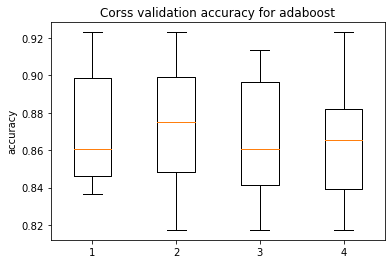


Isolation Forest:
Maximum Accuracy: 92.3076923076923 %
Minimum Accuracy: 83.65384615384616 %
Overall Accuracy: 87.20220313666916 %
Standard Deviation is: 0.0316428636442782

Minimum Covariance Determinant:
Maximum Accuracy: 92.3076923076923 %
Minimum Accuracy: 81.73076923076923 %
Overall Accuracy: 87.2031366691561 %
Standard Deviation is: 0.03588533095090832

Local Outlier Factor:
Maximum Accuracy: 91.34615384615384 %
Minimum Accuracy: 81.73076923076923 %
Overall Accuracy: 86.62247946228528 %
Standard Deviation is: 0.034917831193503966

One-Class SVM:
Maximum Accuracy: 92.3076923076923 %
Minimum Accuracy: 81.73076923076923 %
Overall Accuracy: 86.43297236743838 %
Standard Deviation is: 0.03393689983467563


In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)

lst_accu_stratified_1 = []
lst_precision_stratified_1 = []
lst_recall_stratified_1 = []
lst_f1_score_stratified_1 = []
lst_roc_auc_stratified_1 = []


lst_accu_stratified_2 = []
lst_precision_stratified_2 = []
lst_recall_stratified_2 = []
lst_f1_score_stratified_2 = []
lst_roc_auc_stratified_2 = []

lst_accu_stratified_3 = []
lst_precision_stratified_3 = []
lst_recall_stratified_3 = []
lst_f1_score_stratified_3 = []
lst_roc_auc_stratified_3 = []

lst_accu_stratified_4 = []
lst_precision_stratified_4 = []
lst_recall_stratified_4 = []
lst_f1_score_stratified_4 = []
lst_roc_auc_stratified_4 = []

accuracy = np.zeros((n_fold, 4))

for i, (train_index, val_index) in enumerate(skf.split(X_csv, y_csv)):
    
    print(i)
    
    X_train, X_val = X_csv.iloc[train_index], X_csv.iloc[val_index]
    y_train, y_val = y_csv.iloc[train_index], y_csv.iloc[val_index]
    
    X_train_normalized = preprocessing.normalize(X_train)
    
    X_train_active = X_train_normalized
    
    X_val_normalized = preprocessing.normalize(X_val)
    
    X_val_active = X_val_normalized
    
    # 1. Isolation Forest
    iso = IsolationForest(contamination=0.02)
    yhat = iso.fit_predict(X_train_active)
    mask = yhat != -1
    X_train_ol_1, y_train_ol_1 = X_train_active[mask, :], y_train[mask]
    #print(X_train_ol_1.shape, y_train_ol_1.shape)

    model_ada_1 = AdaBoostClassifier(n_estimators=n_estimators_1, learning_rate=learning_rate_1)
    model_ada_1.fit(X=X_train_ol_1, y=y_train_ol_1)
    y_predict_1 = model_ada_1.predict(X_val_active)
    
    accuracy[i, 0] = np.mean(y_predict_1 == y_val)
    
    # accuracy
    lst_accu_stratified_1.append(model_ada_1.score(X_val_active, y_val))
    
    classification_report_1 = classification_report(y_val,y_predict_1, output_dict=True)
        
    # precision
    lst_precision_stratified_1.append(classification_report_1['-1']['precision'])
    
    # recall
    lst_recall_stratified_1.append(classification_report_1['-1']['recall'])
    
    # f1 score
    lst_f1_score_stratified_1.append(classification_report_1['-1']['f1-score'])
    
    # roc
    # https://www.projectpro.io/recipes/plot-roc-curve-in-python
    y_score1 = model_ada_1.predict_proba(X_val_active)[:,1]
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_score1)
    lst_roc_auc_stratified_1.append(roc_auc_score(y_val, y_score1))
    
    
    
#     print('roc_auc_score for adaboost 1: ', roc_auc_score(y_val, y_score1))
    
#     plt.subplots(1, figsize=(10,10))
#     plt.title('Receiver Operating Characteristic - adaboost 1')
#     plt.plot(false_positive_rate1, true_positive_rate1)
#     plt.plot([0, 1], ls="--")
#     plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    

    # 2. Minimum Covariance Determinant
    ee = EllipticEnvelope(contamination=0.02)
    yhat = ee.fit_predict(X_train_active)
    mask = yhat != -1
    X_train_ol_2, y_train_ol_2 = X_train_active[mask, :], y_train[mask]
    #print(X_train_ol_2.shape, y_train_ol_2.shape)

    model_ada_2 = AdaBoostClassifier(n_estimators=n_estimators_2, learning_rate=learning_rate_2)
    model_ada_2.fit(X=X_train_ol_2, y=y_train_ol_2)
    y_predict_2 = model_ada_2.predict(X_val_active)
    
    accuracy[i, 1] = np.mean(y_predict_2 == y_val)
    lst_accu_stratified_2.append(model_ada_2.score(X_val_active, y_val))
    
    classification_report_2 = classification_report(y_val,y_predict_2, output_dict=True)
        
    # precision
    lst_precision_stratified_2.append(classification_report_2['-1']['precision'])
    
    # recall
    lst_recall_stratified_2.append(classification_report_2['-1']['recall'])
    
    # f1 score
    lst_f1_score_stratified_2.append(classification_report_2['-1']['f1-score'])
    
    # roc
    y_score2 = model_ada_2.predict_proba(X_val_active)[:,1]
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_score2)
    lst_roc_auc_stratified_2.append(roc_auc_score(y_val, y_score2))

    # 3. Local Outlier Factor
    lof = LocalOutlierFactor(contamination=0.02)
    yhat = lof.fit_predict(X_train_active)
    mask = yhat != -1
    X_train_ol_3, y_train_ol_3 = X_train_active[mask, :], y_train[mask]
    #print(X_train_ol_3.shape, y_train_ol_3.shape)

    model_ada_3 = AdaBoostClassifier(n_estimators=n_estimators_3, learning_rate=learning_rate_3)
    model_ada_3.fit(X=X_train_ol_3, y=y_train_ol_3)
    y_predict_3 = model_ada_3.predict(X_val_active)
    
    accuracy[i, 2] = np.mean(y_predict_3 == y_val)
    lst_accu_stratified_3.append(model_ada_3.score(X_val_active, y_val))
    
    classification_report_3 = classification_report(y_val,y_predict_3, output_dict=True)
        
    # precision
    lst_precision_stratified_3.append(classification_report_3['-1']['precision'])
    
    # recall
    lst_recall_stratified_3.append(classification_report_3['-1']['recall'])
    
    # f1 score
    lst_f1_score_stratified_3.append(classification_report_3['-1']['f1-score'])
    
    # roc
    y_score3 = model_ada_3.predict_proba(X_val_active)[:,1]
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_score2)
    lst_roc_auc_stratified_3.append(roc_auc_score(y_val, y_score3))
    
    # 4. One-Class SVM
    ee = OneClassSVM(nu=0.02)
    yhat = ee.fit_predict(X_train_active)
    mask = yhat != -1
    X_train_ol_4, y_train_ol_4 = X_train_active[mask, :], y_train[mask]
    #print(X_train_ol_4.shape, y_train_ol_4.shape)
    
    model_ada_4 = AdaBoostClassifier(n_estimators=n_estimators_4, learning_rate=learning_rate_4)
    model_ada_4.fit(X=X_train_ol_4, y=y_train_ol_4)
    y_predict_4 = model_ada_4.predict(X_val_active)
    
    accuracy[i, 3] = np.mean(y_predict_4 == y_val)
    lst_accu_stratified_4.append(model_ada_4.score(X_val_active, y_val))
    
    classification_report_4 = classification_report(y_val,y_predict_4, output_dict=True)
        
    # precision
    lst_precision_stratified_4.append(classification_report_4['-1']['precision'])
    
    # recall
    lst_recall_stratified_4.append(classification_report_4['-1']['recall'])
    
    # f1 score
    lst_f1_score_stratified_4.append(classification_report_4['-1']['f1-score'])
    
    # roc
    y_score4 = model_ada_4.predict_proba(X_val_active)[:,1]
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_score2)
    lst_roc_auc_stratified_4.append(roc_auc_score(y_val, y_score4))

plt.boxplot(accuracy)
plt.title('Corss validation accuracy for adaboost')
plt.xticks(np.arange(4) + 1, ('1', '2', '3', '4'))
plt.ylabel('accuracy')
plt.show()



# Print the output.
print('\nIsolation Forest:')
print('Maximum Accuracy:',
      max(lst_accu_stratified_1)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified_1)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified_1)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified_1))

print('\nMinimum Covariance Determinant:')
print('Maximum Accuracy:',
      max(lst_accu_stratified_2)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified_2)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified_2)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified_2))

print('\nLocal Outlier Factor:')
print('Maximum Accuracy:',
      max(lst_accu_stratified_3)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified_3)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified_3)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified_3))

print('\nOne-Class SVM:')
print('Maximum Accuracy:',
      max(lst_accu_stratified_4)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified_4)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified_4)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified_4))

In [58]:
labels = ["accuracy", "precision", "recall", "f1-score", "roc-auc"]

print('\nIsolation Forest:')
avg_1 = [mean(lst_accu_stratified_1), mean(lst_precision_stratified_1), mean(lst_recall_stratified_1), mean(lst_f1_score_stratified_1), mean(lst_roc_auc_stratified_1)]
std_1 = [stdev(lst_accu_stratified_1), stdev(lst_precision_stratified_1), stdev(lst_recall_stratified_1), stdev(lst_f1_score_stratified_1), stdev(lst_roc_auc_stratified_1)]
pd.DataFrame({"Metric":labels, "Average":avg_1, "Std dev":std_1})


Isolation Forest:


,Metric,Average,Std dev
0,accuracy,0.872022,0.031643
1,precision,0.881356,0.026055
2,recall,0.960581,0.018281
3,f1-score,0.919115,0.019427
4,roc-auc,0.907861,0.037912


In [59]:
print('\nMinimum Covariance Determinant:')
avg_2 = [mean(lst_accu_stratified_2), mean(lst_precision_stratified_2), mean(lst_recall_stratified_2), mean(lst_f1_score_stratified_2), mean(lst_roc_auc_stratified_2)]
std_2 = [stdev(lst_accu_stratified_2), stdev(lst_precision_stratified_2), stdev(lst_recall_stratified_2), stdev(lst_f1_score_stratified_2), stdev(lst_roc_auc_stratified_2)]
pd.DataFrame({"Metric":labels, "Average":avg_2, "Std dev":std_2})


Minimum Covariance Determinant:


,Metric,Average,Std dev
0,accuracy,0.872031,0.035885
1,precision,0.881406,0.028125
2,recall,0.960565,0.023503
3,f1-score,0.919085,0.022122
4,roc-auc,0.905372,0.039505


In [60]:
print('\nLocal Outlier Factor:')
avg_3 = [mean(lst_accu_stratified_3), mean(lst_precision_stratified_3), mean(lst_recall_stratified_3), mean(lst_f1_score_stratified_3), mean(lst_roc_auc_stratified_3)]
std_3 = [stdev(lst_accu_stratified_3), stdev(lst_precision_stratified_3), stdev(lst_recall_stratified_3), stdev(lst_f1_score_stratified_3), stdev(lst_roc_auc_stratified_3)]
pd.DataFrame({"Metric":labels, "Average":avg_3, "Std dev":std_3})


Local Outlier Factor:


,Metric,Average,Std dev
0,accuracy,0.866225,0.034918
1,precision,0.889771,0.028448
2,recall,0.940182,0.025427
3,f1-score,0.914038,0.021961
4,roc-auc,0.907443,0.039037


In [61]:
print('\nOne-Class SVM:')
avg_4 = [mean(lst_accu_stratified_4), mean(lst_precision_stratified_4), mean(lst_recall_stratified_4), mean(lst_f1_score_stratified_4), mean(lst_roc_auc_stratified_4)]
std_4 = [stdev(lst_accu_stratified_4), stdev(lst_precision_stratified_4), stdev(lst_recall_stratified_4), stdev(lst_f1_score_stratified_4), stdev(lst_roc_auc_stratified_4)]
pd.DataFrame({"Metric":labels, "Average":avg_4, "Std dev":std_4})


One-Class SVM:


,Metric,Average,Std dev
0,accuracy,0.864330,0.033937
1,precision,0.880326,0.028934
2,recall,0.950373,0.019240
3,f1-score,0.913827,0.021029
4,roc-auc,0.898160,0.035964
